In [1]:
import json
import csv
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support as prf_score
from sklearn.metrics import accuracy_score as accuracy_score
import Levenshtein as lv
from difflib import SequenceMatcher
import affinegap
import scipy
import timeit
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from scipy.stats import randint as sp_randint
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)

In [2]:
entity_path = pd.read_csv('data/match/entity.csv')
resolution_train_path = pd.read_csv('data/training/resolution_training.csv')
resolution_test_path = pd.read_csv('data/test/resolution_test.csv')
resolution_test_path_v2 = pd.read_csv('data/test/resolution_test.csv')

In [3]:
entity_path.head()

,id,name
0,1,"""Donald Trump"""
1,2,"""Robert Mueller"""
2,3,"""Michael Cohen"""
3,4,"""Chris Wallace"""
4,5,"""William Barr"""


In [4]:
resolution_train_path.head()


,id,name,aka
0,1,Trump,6064
1,2,Mueller,1381
2,3,Cohen,1347
3,4,WALLACE,1129
4,5,Barr,814


In [5]:
resolution_test_path.head()

,id,name,aka
0,12,Clinton,Hillary Clinton
1,35,Nancy Pelosi,NaN
2,36,Barack Obama,NaN
3,37,Robert Mueller,NaN
4,38,Michael Cohen,NaN


In [6]:
def clean_entity(dataset):
        #OVERALL (NaN and None)
        dataset.replace('', np.nan, inplace=True)
        dataset.fillna(value=np.nan, inplace=True)
        #FEATURE: NAME
        dataset['name'] = dataset['name'].str.upper()
        dataset['name'] = dataset['name'].str.replace(' ', '').str.replace('É', 'E').str.replace('&', 'AND').str.replace('[^a-zA-Z0-9]', '')
        return dataset

In [7]:
def clean_resolution(dataset):
        #OVERALL (NaN and None)
        dataset.replace('', np.nan, inplace=True)
        dataset.fillna(value=np.nan, inplace=True)
        # Dropping count
        dataset.drop(['aka'],axis=1, inplace=True)
        #FEATURE: NAME
        dataset['name'] = dataset['name'].str.upper()
        dataset['name'] = dataset['name'].str.replace(' ', '').str.replace('É', 'E').str.replace('&', 'AND').str.replace('[^a-zA-Z0-9]', '')
        return dataset

In [8]:
def replace(row):
    if row['aka'] is not np.nan:
        val = row['aka']
    else: 
        val = row['name']
    return val

In [9]:
def clean_resolution_v2(dataset):
        #OVERALL (NaN and None)
        dataset.replace('', np.nan, inplace=True)
        dataset.fillna(value=np.nan, inplace=True)
       
        
        #FEATURE: NAME
        dataset['temp_name'] = dataset.apply(replace, axis=1)
        dataset['temp_name'] = dataset['temp_name'].str.upper()
        dataset['temp_name'] = dataset['temp_name'].str.replace(' ', '').str.replace('É', 'E').str.replace('&', 'AND').str.replace('[^a-zA-Z0-9]', '')
        dataset['name'] = dataset['temp_name']
        # Dropping count
        dataset.drop(['aka', 'temp_name'],axis=1, inplace=True)
        return dataset

In [10]:
entity = clean_entity(entity_path)
resolution_train = clean_resolution(resolution_train_path)
resolution_test = clean_resolution(resolution_test_path)
resolution_test_v2 = clean_resolution_v2(resolution_test_path_v2)

In [11]:
entity.head()

,id,name
0,1,DONALDTRUMP
1,2,ROBERTMUELLER
2,3,MICHAELCOHEN
3,4,CHRISWALLACE
4,5,WILLIAMBARR


In [12]:
resolution_train.head()

,id,name
0,1,TRUMP
1,2,MUELLER
2,3,COHEN
3,4,WALLACE
4,5,BARR


In [13]:
resolution_test.head()

,id,name
0,12,CLINTON
1,35,NANCYPELOSI
2,36,BARACKOBAMA
3,37,ROBERTMUELLER
4,38,MICHAELCOHEN


In [14]:
resolution_test_v2.head()

,id,name
0,12,HILLARYCLINTON
1,35,NANCYPELOSI
2,36,BARACKOBAMA
3,37,ROBERTMUELLER
4,38,MICHAELCOHEN


In [15]:
def create_dataframe(entity, resolution):
        entity_id_list = list(entity['id'])
        resolution_id_list = list(resolution['id'])
        length_eids = len(entity_id_list)
        length_rids = len(resolution_id_list)

        resolution_id_repeated = np.repeat(resolution_id_list,length_eids)
        #ex. [0,0,0,1,1,1,2,2,2]
        entity_id_tiled = np.tile(entity_id_list,length_rids)
        #ex. [0,1,2,0,1,2,0,1,2]
        df = pd.DataFrame({'resolution_id': resolution_id_repeated,'entity_id':entity_id_tiled})
        #ex. [0,0] [0,1] [0,2] [1,0] [1,1] [1,2] [2,0] [2,1] [2,2]
        entity = entity.add_suffix('_E')
        resolution = resolution.add_suffix('_R')
        df = df.merge(entity,left_on='entity_id',right_on=['id_E'],how='left').merge(resolution,left_on='resolution_id',right_on='id_R', how='left')
        df['entity_id'] = df['entity_id'].astype(str)
        df['resolution_id'] = df['resolution_id'].astype(str)
        df['unique_id'] = df['entity_id'] + df['resolution_id']
        return df

In [16]:
df_train = create_dataframe(entity, resolution_train)
df_test = create_dataframe(entity, resolution_test)
df_test_v2 = create_dataframe(entity, resolution_test_v2)

In [17]:
df_train.head()

,resolution_id,entity_id,id_E,name_E,id_R,name_R,unique_id
0,1,1,1,DONALDTRUMP,1,TRUMP,11
1,1,2,2,ROBERTMUELLER,1,TRUMP,21
2,1,3,3,MICHAELCOHEN,1,TRUMP,31
3,1,4,4,CHRISWALLACE,1,TRUMP,41
4,1,5,5,WILLIAMBARR,1,TRUMP,51


In [18]:
df_test.head()

,resolution_id,entity_id,id_E,name_E,id_R,name_R,unique_id
0,12,1,1,DONALDTRUMP,12,CLINTON,112
1,12,2,2,ROBERTMUELLER,12,CLINTON,212
2,12,3,3,MICHAELCOHEN,12,CLINTON,312
3,12,4,4,CHRISWALLACE,12,CLINTON,412
4,12,5,5,WILLIAMBARR,12,CLINTON,512


In [19]:
df_test_v2.head()

,resolution_id,entity_id,id_E,name_E,id_R,name_R,unique_id
0,12,1,1,DONALDTRUMP,12,HILLARYCLINTON,112
1,12,2,2,ROBERTMUELLER,12,HILLARYCLINTON,212
2,12,3,3,MICHAELCOHEN,12,HILLARYCLINTON,312
3,12,4,4,CHRISWALLACE,12,HILLARYCLINTON,412
4,12,5,5,WILLIAMBARR,12,HILLARYCLINTON,512


In [20]:
def either_string_is_null(str1,str2):
        if pd.isnull(str1) or pd.isnull(str2):
            return True
        else:
            return False

In [21]:
def aff(str1,str2):
        if either_string_is_null(str1,str2):
            return np.nan
        else:
            return affinegap.affineGapDistance(str1,str2)

In [22]:
def lev(str1,str2):
        if either_string_is_null(str1,str2):
            return np.nan
        else:
            return lv.distance(str1, str2)

In [23]:
def sim(str1, str2):
        if either_string_is_null(str1,str2):
            return np.nan
        else:
            return SequenceMatcher(None, str1, str2).ratio()

In [24]:
def lenlongcommon(str1,str2):
        if either_string_is_null(str1,str2):
            return np.nan
        else:
        # initialize SequenceMatcher object with
         # input string
            seqMatch = SequenceMatcher(None,str1,str2)

             # find match of longest sub-string
             # output will be like Match(a=0, b=0, size=5)
            match = seqMatch.find_longest_match(0, len(str1), 0, len(str2))
        return match.size

In [25]:
def add_features(df):
        #FEATURE: PHONE

        #perfect match
        df['name_perfect_match'] = df['name_E'] == df['name_R']

        a = timeit.default_timer()

        col = 'name'
        print('aff,lev,sim,llc')
        print(col)
        df[col+'_aff'] = df[[col+'_E',col+'_R']].apply(lambda x: aff(*x), axis=1)
        #Your statements here

        b = timeit.default_timer()
        print(b-a)

        df[col+'_lev'] = df[[col+'_E',col+'_R']].apply(lambda x: lev(*x), axis=1)
        c = timeit.default_timer()
        print(c-b)

        df[col+'_sim'] = df[[col+'_E',col+'_R']].apply(lambda x: sim(*x), axis=1)
        d = timeit.default_timer()
        print(d-c)

        df[col+'_llc'] = df[[col+'_E',col+'_R']].apply(lambda x: lenlongcommon(*x), axis=1)
        e = timeit.default_timer()
        print(e-d)

        return df

In [26]:
df_train_with_created_features = add_features(df_train)
df_test_with_created_features = add_features(df_test)
df_test_with_created_features_v2 = add_features(df_test_v2)

aff,lev,sim,llc
name
5.324179084999999
4.841180413
13.434722295
7.949403365000002
aff,lev,sim,llc
name
0.08411376000000104
0.07445619599999986
0.23383232999999848
0.13581671000000028
aff,lev,sim,llc
name
0.08377198099999816
0.08211236900000074
0.2321704179999955
0.14243995700000056


In [27]:
# df_train_with_created_features['name_sim'] = df_train_with_created_features['name_sim'] * 100
# df_test_with_created_features['name_sim'] = df_test_with_created_features['name_sim'] * 100

In [28]:
df_train_with_created_features.head()

,resolution_id,entity_id,id_E,name_E,id_R,name_R,unique_id,name_perfect_match,name_aff,name_lev,name_sim,name_llc
0,1,1,1,DONALDTRUMP,1,TRUMP,11,False,54.750,6,0.625000,5
1,1,2,2,ROBERTMUELLER,1,TRUMP,21,False,63.250,11,0.222222,1
2,1,3,3,MICHAELCOHEN,1,TRUMP,31,False,62.375,12,0.117647,1
3,1,4,4,CHRISWALLACE,1,TRUMP,41,False,62.375,11,0.117647,1
4,1,5,5,WILLIAMBARR,1,TRUMP,51,False,61.500,10,0.125000,1


In [29]:
df_test_with_created_features.head()

,resolution_id,entity_id,id_E,name_E,id_R,name_R,unique_id,name_perfect_match,name_aff,name_lev,name_sim,name_llc
0,12,1,1,DONALDTRUMP,12,CLINTON,112,False,81.750,10,0.222222,2
1,12,2,2,ROBERTMUELLER,12,CLINTON,212,False,83.500,12,0.100000,1
2,12,3,3,MICHAELCOHEN,12,CLINTON,312,False,76.125,9,0.315789,1
3,12,4,4,CHRISWALLACE,12,CLINTON,412,False,72.625,10,0.210526,1
4,12,5,5,WILLIAMBARR,12,CLINTON,512,False,81.750,9,0.222222,2


In [30]:
df_test_with_created_features_v2.head()

,resolution_id,entity_id,id_E,name_E,id_R,name_R,unique_id,name_perfect_match,name_aff,name_lev,name_sim,name_llc
0,12,1,1,DONALDTRUMP,12,HILLARYCLINTON,112,False,124.875,13,0.160000,2
1,12,2,2,ROBERTMUELLER,12,HILLARYCLINTON,212,False,145.125,13,0.222222,2
2,12,3,3,MICHAELCOHEN,12,HILLARYCLINTON,312,False,105.000,10,0.384615,1
3,12,4,4,CHRISWALLACE,12,HILLARYCLINTON,412,False,125.000,12,0.461538,3
4,12,5,5,WILLIAMBARR,12,HILLARYCLINTON,512,False,94.875,11,0.400000,3


In [31]:
#Add matches column
matches_path = pd.read_csv('data/match/match.csv')
matches_path['entity_id'] = matches_path['entity_id'].astype(str)
matches_path['resolution_id'] = matches_path['resolution_id'].astype(str)
matches = matches_path.rename(index=str,columns={'entity_id':'true_entity_id'})
df_train_with_created_features['resolution_id'] = df_train_with_created_features['resolution_id'].astype(str)
df_train_with_created_features_with_EID = df_train_with_created_features.merge(matches, on='resolution_id', how='inner')


In [32]:
df_train_with_created_features_with_EID.head()

,resolution_id,entity_id,id_E,name_E,id_R,name_R,unique_id,name_perfect_match,name_aff,name_lev,name_sim,name_llc,true_entity_id
0,1,1,1,DONALDTRUMP,1,TRUMP,11,False,54.750,6,0.625000,5,1
1,1,2,2,ROBERTMUELLER,1,TRUMP,21,False,63.250,11,0.222222,1,1
2,1,3,3,MICHAELCOHEN,1,TRUMP,31,False,62.375,12,0.117647,1,1
3,1,4,4,CHRISWALLACE,1,TRUMP,41,False,62.375,11,0.117647,1,1
4,1,5,5,WILLIAMBARR,1,TRUMP,51,False,61.500,10,0.125000,1,1


In [33]:
#add a target
df_train_with_created_features_with_EID['target'] = df_train_with_created_features_with_EID['entity_id']==df_train_with_created_features_with_EID['true_entity_id']

features_to_keep = ['name_perfect_match']+[col for col in df_train_with_created_features_with_EID.columns if 'aff' in col or 'lev' in col or 'sim' in col or 'llc' in col]

#clean train data
X_train = df_train_with_created_features_with_EID[features_to_keep]
id_mapping_train = df_train_with_created_features_with_EID[['entity_id', 'resolution_id']].astype(int)
# clean test data
X_test = df_test_with_created_features[features_to_keep]
id_mapping_test = df_test_with_created_features[['entity_id', 'resolution_id']].astype(int)
# clean test data v2
X_test_v2 = df_test_with_created_features_v2[features_to_keep]
id_mapping_test_v2 = df_test_with_created_features_v2[['entity_id', 'resolution_id']].astype(int)
#Create target
target = df_train_with_created_features_with_EID['target']

#deal with NaN to pass into the random forest
X_train = X_train.fillna(-10000, axis =1).astype(int)
X_test = X_test.fillna(-10000, axis =1).astype(int)
X_test_v2 = X_test_v2.fillna(-10000, axis =1).astype(int)

In [34]:
target.head()


0     True
1    False
2    False
3    False
4    False
Name: target, dtype: bool

In [35]:
X_train.head()

,name_perfect_match,name_aff,name_lev,name_sim,name_llc
0,0,54,6,0,5
1,0,63,11,0,1
2,0,62,12,0,1
3,0,62,11,0,1
4,0,61,10,0,1


In [36]:
X_test_v2.head()

,name_perfect_match,name_aff,name_lev,name_sim,name_llc
0,0,124,13,0,2
1,0,145,13,0,2
2,0,105,10,0,1
3,0,125,12,0,3
4,0,94,11,0,3


In [37]:
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In [38]:
from sklearn.feature_selection import SelectFromModel
clf1 = RandomForestClassifier()

# Set a minimum threshold of 0.25
sfm = SelectFromModel(clf1, threshold='.15*mean')
sfm.fit(X_train, target)
X_train = sfm.transform(X_train)
X_test = sfm.transform(X_test)
X_test_v2 = sfm.transform(X_test_v2)
param_grid = {"max_depth": [None],
              "max_features": ['log2','sqrt'],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
             "class_weight": [None]}


In [39]:
grid = GridSearchCV(RandomForestClassifier(random_state=0),param_grid=param_grid, cv=StratifiedKFold())
grid.fit(X_train, target)
print(grid.cv_results_)

predict_train = grid.predict_proba(X_train)
predict_test = grid.predict_proba(X_test)
predict_test_v2 = grid.predict_proba(X_test_v2)
predict1 = pd.DataFrame(predict_train)
predict1_test = pd.DataFrame(predict_test)
predict1_test_v2 = pd.DataFrame(predict_test_v2)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_test_v2 = pd.DataFrame(X_test_v2)


{'mean_fit_time': array([0.02257093, 0.01989023, 0.01575947, 0.01567213, 0.01457461,
       0.01435701, 0.01368054, 0.01427913]), 'std_fit_time': array([0.00140867, 0.00179168, 0.00026369, 0.00036724, 0.00063865,
       0.00053945, 0.00045135, 0.00123452]), 'mean_score_time': array([0.00278131, 0.00234373, 0.00203514, 0.00201527, 0.00197117,
       0.00195901, 0.00195138, 0.00232442]), 'std_score_time': array([2.81321149e-04, 2.18988240e-04, 1.76010407e-05, 4.82942647e-05,
       5.41307610e-05, 7.11655386e-05, 1.99554436e-05, 3.79431781e-04]), 'param_bootstrap': masked_array(data=[True, True, True, True, False, False, False, False],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_class_weight': masked_array(data=[None, None, None, None, None, None, None, None],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_criterion

In [40]:
predict1.head()

,0,1
0,0.1,0.9
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0


In [41]:
predict1_test.head()

,0,1
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0


In [42]:
predict1_test_v2.head()

,0,1
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0


In [43]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [44]:
#X_train['predict_proba'] = predict1[1]
X_test['predict_proba'] = predict1_test[1]


# add id mapping
#X_train_with_id = pd.concat([X_train,id_mapping_train],axis=1)
X_test_with_id = pd.concat([X_test,id_mapping_test],axis=1)


header = ['threshhold', 'accuracy', 'precision', 'recall', 'f1']
metric_list = pd.DataFrame(columns=header)
metric_list.set_index('threshhold',inplace = True)

for index in range(0, 10):
    index = index /10
    print('For threshhold: ' + str(index))
    #add predicted probability
    #X_train_with_id['y_pred'] = (X_train_with_id['predict_proba']>index).astype(int)
    X_test_with_id['y_pred'] = (X_test_with_id['predict_proba']>index).astype(int)
    X_test_with_id['entity_id'] = X_test_with_id['entity_id'].astype(int)
    X_test_with_id['resolution_id'] = X_test_with_id['resolution_id'].astype(int)
    X_test_with_id = X_test_with_id.sort_values(['resolution_id', 'entity_id'], ascending=[True, True])
    X_test_with_name = X_test_with_id.merge(entity,left_on='entity_id',right_on=['id'],how='left').merge(resolution_test,left_on='resolution_id',right_on='id', how='left')
    X_test_with_name.drop(['id_x', 'id_y'],axis=1, inplace=True)
    X_test_with_name.rename(columns = {'name_x':'entity_name', 'name_y':'resolution_name'}, inplace=True)
    X_predicted = X_test_with_name[['resolution_id', 'entity_id', 'resolution_name', 'entity_name', 'predict_proba', 'y_pred']]
    X_predicted.head()
    matches['true_entity_id'] = matches['true_entity_id'].astype(int)
    matches['resolution_id'] = matches['resolution_id'].astype(int)
    compare_output = X_predicted.merge(matches, on='resolution_id',how='inner')
    compare_output['y_actual'] = (compare_output['entity_id'] == compare_output['true_entity_id']).astype(int)
    #compare_output.head()
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(compare_output['y_actual'], compare_output['y_pred'] )
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(compare_output['y_actual'], compare_output['y_pred'])
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(compare_output['y_actual'], compare_output['y_pred'])
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(compare_output['y_actual'], compare_output['y_pred'])
    print('F1 score: %f' % f1)
    print('')
    #average = (accuracy + precision + recall + f1) / 4
    #print('Average score: %f' % average)
    print('')
    metric_list.loc[index] = [accuracy, precision, recall, f1]
    output_path = 'result/v1/entity_resolution_t' + str(int(index*10)) + '.csv'
    final_test_output = compare_output[compare_output['y_pred']==1][['resolution_name', 'entity_name', 'y_pred', 'y_actual', 'predict_proba']]
    final_test_output.to_csv(output_path, index = False)
    



For threshhold: 0.0
Accuracy: 0.988515
Precision: 0.547368
Recall: 1.000000
F1 score: 0.707483


For threshhold: 0.1
Accuracy: 0.994925
Precision: 0.739130
Recall: 0.980769
F1 score: 0.842975


For threshhold: 0.2
Accuracy: 0.995726
Precision: 0.772727
Recall: 0.980769
F1 score: 0.864407


For threshhold: 0.3
Accuracy: 0.996795
Precision: 0.844828
Recall: 0.942308
F1 score: 0.890909


For threshhold: 0.4
Accuracy: 0.997062
Precision: 0.859649
Recall: 0.942308
F1 score: 0.899083


For threshhold: 0.5
Accuracy: 0.997329
Precision: 0.888889
Recall: 0.923077
F1 score: 0.905660


For threshhold: 0.6
Accuracy: 0.992521
Precision: 0.833333
Recall: 0.576923
F1 score: 0.681818


For threshhold: 0.7
Accuracy: 0.991453
Precision: 0.833333
Recall: 0.480769
F1 score: 0.609756


For threshhold: 0.8
Accuracy: 0.990118
Precision: 0.800000
Recall: 0.384615
F1 score: 0.519481


For threshhold: 0.9
Accuracy: 0.989583
Precision: 0.809524
Recall: 0.326923
F1 score: 0.465753




In [45]:
import matplotlib.pyplot as plt

In [46]:
metric_list.head()

,accuracy,precision,recall,f1
threshhold,,,,
0.0,0.988515,0.547368,1.000000,0.707483
0.1,0.994925,0.739130,0.980769,0.842975
0.2,0.995726,0.772727,0.980769,0.864407
0.3,0.996795,0.844828,0.942308,0.890909
0.4,0.997062,0.859649,0.942308,0.899083


<Figure size 432x288 with 0 Axes>

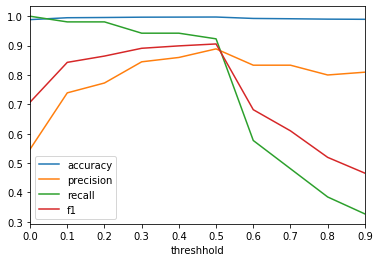

In [47]:
plt.figure()
metric_list.plot()

plt.show()

<Figure size 432x288 with 0 Axes>

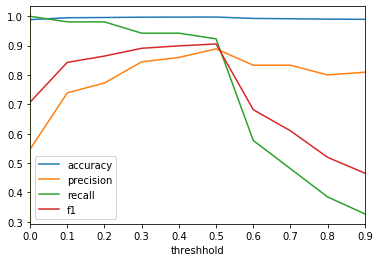

In [48]:
#highest recall
plt.figure()
metric_list.plot()
plt.axvline(x=0.0,color='yellow',linestyle='--')
plt.show()


<Figure size 432x288 with 0 Axes>

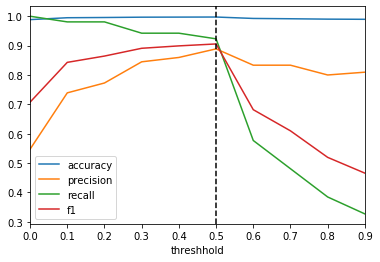

In [69]:
#highest precision
plt.figure()
metric_list.plot()
plt.axvline(x=0.5,color='k',linestyle='--')
plt.show()

<Figure size 432x288 with 0 Axes>

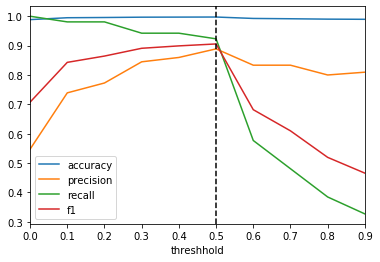

In [70]:
#highest f1
plt.figure()
metric_list.plot()
plt.axvline(x=0.5,color='k',linestyle='--')
plt.show()

In [51]:
X_test_v2['predict_proba'] = predict1_test_v2[1]
X_test_with_id_v2 = pd.concat([X_test_v2,id_mapping_test_v2],axis=1)

header = ['threshhold', 'accuracy', 'precision', 'recall', 'f1']
metric_list_v2 = pd.DataFrame(columns=header)
metric_list_v2.set_index('threshhold',inplace = True)

for index in range(0, 10):
    index = index /10
    print('For threshhold: ' + str(index))
    #add predicted probability
    #X_train_with_id['y_pred'] = (X_train_with_id['predict_proba']>index).astype(int)
    X_test_with_id_v2['y_pred'] = (X_test_with_id_v2['predict_proba']>index).astype(int)
    X_test_with_id_v2['entity_id'] = X_test_with_id_v2['entity_id'].astype(int)
    X_test_with_id_v2['resolution_id'] = X_test_with_id_v2['resolution_id'].astype(int)
    X_test_with_id_v2 = X_test_with_id_v2.sort_values(['resolution_id', 'entity_id'], ascending=[True, True])
    X_test_with_name_v2 = X_test_with_id_v2.merge(entity,left_on='entity_id',right_on=['id'],how='left').merge(resolution_test_v2,left_on='resolution_id',right_on='id', how='left')
    X_test_with_name_v2.drop(['id_x', 'id_y'],axis=1, inplace=True)
    X_test_with_name_v2.rename(columns = {'name_x':'entity_name', 'name_y':'resolution_name'}, inplace=True)
    X_predicted_v2 = X_test_with_name_v2[['resolution_id', 'entity_id', 'resolution_name', 'entity_name', 'predict_proba', 'y_pred']]
    X_predicted_v2.head()
    matches['true_entity_id'] = matches['true_entity_id'].astype(int)
    matches['resolution_id'] = matches['resolution_id'].astype(int)
    compare_output_v2 = X_predicted_v2.merge(matches, on='resolution_id',how='inner')
    compare_output_v2['y_actual'] = (compare_output_v2['entity_id'] == compare_output_v2['true_entity_id']).astype(int)
    #compare_output.head()
    # accuracy: (tp + tn) / (p + n)
    accuracy_v2 = accuracy_score(compare_output_v2['y_actual'], compare_output_v2['y_pred'])
    print('Accuracy: %f' % accuracy_v2)
    # precision tp / (tp + fp)
    precision_v2 = precision_score(compare_output_v2['y_actual'], compare_output_v2['y_pred'])
    print('Precision: %f' % precision_v2)
    # recall: tp / (tp + fn)
    recall_v2 = recall_score(compare_output_v2['y_actual'], compare_output_v2['y_pred'])
    print('Recall: %f' % recall_v2)
    # f1: 2 tp / (2 tp + fp + fn)
    f1_v2 = f1_score(compare_output_v2['y_actual'], compare_output_v2['y_pred'])
    print('F1 score: %f' % f1_v2)
    print('')
#     average_v2 = (accuracy_v2 + precision_v2 + recall_v2 + f1_v2) / 4
#     print('Average score: %f' % accuracy_v2)
#     print('')
    
    metric_list_v2.loc[index] = [accuracy_v2, precision_v2, recall_v2, f1_v2]
    output_path_v2 = 'result/v2/entity_resolution_t' + str(int(index*10)) + '.csv'
    final_test_output_v2 = compare_output_v2[compare_output_v2['y_pred']==1][['resolution_name', 'entity_name', 'y_pred', 'y_actual', 'predict_proba']]
    final_test_output_v2.to_csv(output_path_v2, index = False)

For threshhold: 0.0
Accuracy: 0.988248
Precision: 0.541667
Recall: 1.000000
F1 score: 0.702703

For threshhold: 0.1
Accuracy: 0.995459
Precision: 0.753623
Recall: 1.000000
F1 score: 0.859504

For threshhold: 0.2
Accuracy: 0.995994
Precision: 0.776119
Recall: 1.000000
F1 score: 0.873950

For threshhold: 0.3
Accuracy: 0.997863
Precision: 0.866667
Recall: 1.000000
F1 score: 0.928571

For threshhold: 0.4
Accuracy: 0.998397
Precision: 0.896552
Recall: 1.000000
F1 score: 0.945455

For threshhold: 0.5
Accuracy: 0.998932
Precision: 0.928571
Recall: 1.000000
F1 score: 0.962963

For threshhold: 0.6
Accuracy: 0.994391
Precision: 0.897436
Recall: 0.673077
F1 score: 0.769231

For threshhold: 0.7
Accuracy: 0.993323
Precision: 0.885714
Recall: 0.596154
F1 score: 0.712644

For threshhold: 0.8
Accuracy: 0.991720
Precision: 0.862069
Recall: 0.480769
F1 score: 0.617284

For threshhold: 0.9
Accuracy: 0.990652
Precision: 0.840000
Recall: 0.403846
F1 score: 0.545455



<Figure size 432x288 with 0 Axes>

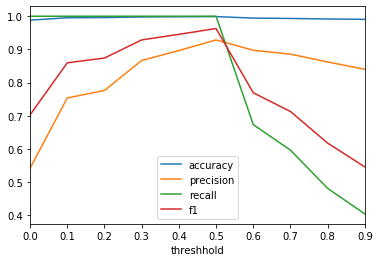

In [52]:
plt.figure()
metric_list_v2.plot()
plt.show()

<Figure size 432x288 with 0 Axes>

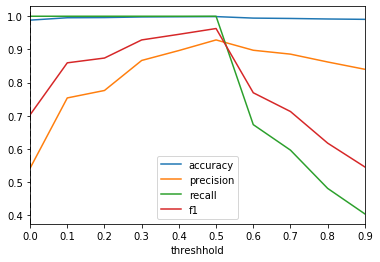

In [53]:
#highest recall
plt.figure()
metric_list_v2.plot()
plt.axvline(x=0.0,color='k',linestyle='--')
plt.show()

<Figure size 432x288 with 0 Axes>

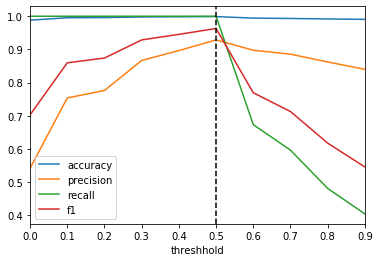

In [67]:
#highest precision
plt.figure()
metric_list_v2.plot()
plt.axvline(x=0.5,color='k',linestyle='--')
plt.show()

<Figure size 432x288 with 0 Axes>

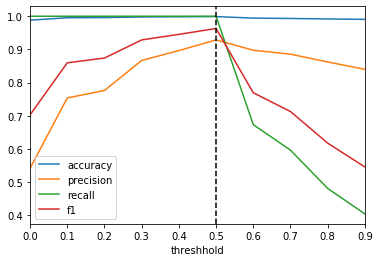

In [68]:
#highest f1
plt.figure()
metric_list_v2.plot()
plt.axvline(x=0.5,color='k',linestyle='--')
plt.show()

In [56]:
precision_compare = pd.merge(metric_list[['precision']], metric_list_v2[['precision']], left_index=True, right_index=True)
recall_compare = pd.merge(metric_list[['recall']], metric_list_v2[['recall']], left_index=True, right_index=True)
f1_compare = pd.merge(metric_list[['f1']], metric_list_v2[['f1']], left_index=True, right_index=True)













In [57]:
precision_compare.head()

,precision_x,precision_y
threshhold,,
0.0,0.547368,0.541667
0.1,0.739130,0.753623
0.2,0.772727,0.776119
0.3,0.844828,0.866667
0.4,0.859649,0.896552


In [58]:
recall_compare.head()

,recall_x,recall_y
threshhold,,
0.0,1.000000,1.0
0.1,0.980769,1.0
0.2,0.980769,1.0
0.3,0.942308,1.0
0.4,0.942308,1.0


In [59]:
f1_compare.head()

,f1_x,f1_y
threshhold,,
0.0,0.707483,0.702703
0.1,0.842975,0.859504
0.2,0.864407,0.873950
0.3,0.890909,0.928571
0.4,0.899083,0.945455


<Figure size 432x288 with 0 Axes>

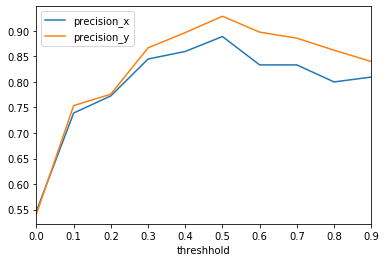

In [60]:
plt.figure()
precision_compare.plot()
plt.show()

<Figure size 432x288 with 0 Axes>

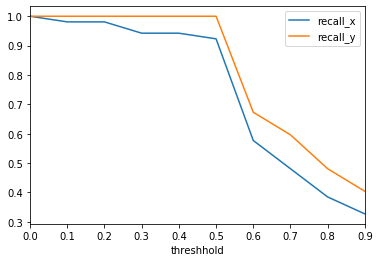

In [61]:
plt.figure()
recall_compare.plot()
plt.show()

<Figure size 432x288 with 0 Axes>

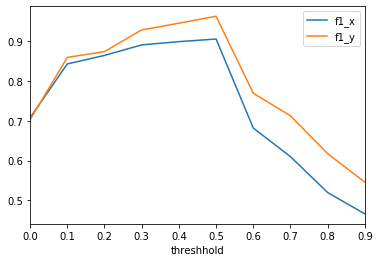

In [62]:
plt.figure()
f1_compare.plot()
plt.show()

In [63]:
test_highest_prob_path = "result/v2/entity_resolution_t0.csv"
test_highest_prob_df = pd.read_csv(test_highest_prob_path)
test_highest_prob_df.head()

,resolution_name,entity_name,y_pred,y_actual,predict_proba
0,HILLARYCLINTON,HILLARYCLINTON,1,1,0.713636
1,NANCYPELOSI,NANCYPELOSI,1,1,1.000000
2,BARACKOBAMA,BARACKOBAMA,1,1,1.000000
3,ROBERTMUELLER,ROBERTMUELLER,1,1,0.589296
4,ROBERTMUELLER,JOHNROBERTS,1,0,0.200000


In [64]:
test_highest_prob_df = test_highest_prob_df.groupby('resolution_name', group_keys=False).apply(lambda x: x.loc[x.predict_proba.idxmax()])
test_highest_prob_df.head()

,resolution_name,entity_name,y_pred,y_actual,predict_proba
resolution_name,,,,,
BARACKOBAMA,BARACKOBAMA,BARACKOBAMA,1,1,1.000000
BERNIESANDERS,BERNIESANDERS,BERNIESANDERS,1,1,0.589296
BETOOROURKE,BETOOROURKE,BETOOROURKE,1,1,1.000000
BRETTKAVANAUGH,BRETTKAVANAUGH,BRETTKAVANAUGH,1,1,0.713636
CHRISWALLACE,CHRISWALLACE,CHRISWALLACE,1,1,0.589296


In [65]:
precision_v3 = precision_score(test_highest_prob_df['y_actual'], test_highest_prob_df['y_pred'])
print(precision_v3)

0.9555555555555556


In [66]:
test_highest_prob_df.to_csv("result/v3/entity_resolution_test.csv")